In [1]:
!kaggle datasets download -d mnkbiswas/pixmo-points-50k
!unzip -q pixmo-points-50k.zip
!rm pixmo-points-50k.zip

Dataset URL: https://www.kaggle.com/datasets/mnkbiswas/pixmo-points-50k
License(s): ODC Attribution License (ODC-By)
100%|██████████████████████████████████████▉| 6.45G/6.46G [00:48<00:00, 128MB/s]
100%|███████████████████████████████████████| 6.46G/6.46G [00:48<00:00, 144MB/s]


In [11]:
!wandb login --verify 6a593d3306168e65188791581032f7d848b9bfbb

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image
import pickle
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
from transformers import AutoTokenizer
from transformers.image_utils import load_image
import os
import wandb
from datetime import datetime
from torch.optim.lr_scheduler import OneCycleLR


# --- Constants (Copied from your original code for completeness) ---
# Model architecture constants
IMAGE_SIZE = 512
PATCH_SIZE = 16
HIDDEN_DIM = 256  # smolvlm has 576 -> Keep this consistent for text and projected image
CONTEXT_LENGTH = 1536 # Max combined length: (512/16)**2 + 1 (CLS) + 512 = 1024 + 1 + 512 = 1537. Adjust if needed. Let's keep 1536 for now.
TEXT_LENGTH = 512 # Max *text* length
DROPOUT = 0.1 # Slightly increased dropout might help regularization
NUM_HEADS = 8 # Reduced heads for smaller HIDDEN_DIM might be more stable
NUM_LAYERS = 12 # Reduced layers might be easier to train initially

# Training constants
BATCH_SIZE = 4 # Increased batch size slightly if GPU memory allows
LEARNING_RATE = 3e-4 # Common starting point for transformers
DTYPE = torch.float32 #torch.bfloat16
GRAD_ACCUMULATION_STEPS = 8 # Adjusted accumulation
# Image normalization constants
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

IMAGE_SIZE = 512
PATCH_SIZE = 16
HIDDEN_DIM = 256
CONTEXT_LENGTH = 1536
TEXT_LENGTH = 512 # Max length for *target* sequence (coords)
PROMPT_LENGTH = 64 # Max length for *prompt* sequence (description) - Adjust as needed
DROPOUT = 0.1
NUM_HEADS = 8
NUM_LAYERS = 12 # Keep moderate layers
BATCH_SIZE = 2
LEARNING_RATE = 1e-3 # Lower LR might be needed with contrastive loss
DTYPE = torch.float32
GRAD_ACCUMULATION_STEPS = 8
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_LOCATION = "./images/"
NUM_BINS = 32
SHARED_EMBED_DIM = 256 # Dimension for contrastive space
LAMBDA_CONTRASTIVE = 2 # Weight for contrastive loss - TUNE THIS
LAMBDA_REGRESSION = 2

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Image storage location
IMAGE_LOCATION = "./images/"
NUM_BINS = 32

# --- Tokenizer and Data Loading (Assume unchanged from your code) ---
def get_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    point_tokens = [f"coord_bin_{i}" for i in range(0, NUM_BINS)]
    new_tokens = [
        "<point_start>", "<point_end>", "<result_start>",
        "<result_end>", "<pointx_start>", "<pointx_end>",
        "<pointy_start>", "<pointy_end>", "<img_embed>", # We might not explicitly use <img_embed> token if we prepend
        *point_tokens
    ]
    tokenizer.add_tokens(new_tokens)
    # Ensure pad token is set (GPT2 usually doesn't have one by default)
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or use eos_token if preferred
        # tokenizer.pad_token_id = tokenizer.eos_token_id # Alternative if you want padding to be EOS

    # Resize model embeddings if pad token was added
    # This step should be done *after* defining the model that uses the tokenizer
    # model.resize_token_embeddings(len(tokenizer))

    print(f"Tokenizer pad token: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}")
    print(f"Tokenizer EOS token: {tokenizer.eos_token}, ID: {tokenizer.eos_token_id}")

    # Check if pad token ID is valid
    if tokenizer.pad_token_id is None:
         raise ValueError("Tokenizer pad token ID is not set!")

    return tokenizer, len(tokenizer)

def image_to_tensor(image, image_size=IMAGE_SIZE):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
    ])
    return transform(image)

def tensor_to_image(tensor):
    tensor = tensor.clone().detach()
    if tensor.is_cuda:
        tensor = tensor.cpu()
    mean = torch.tensor(IMAGE_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGE_STD).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    image_np = tensor.numpy().transpose(1, 2, 0)
    image_np = (image_np * 255).astype(np.uint8)
    return Image.fromarray(image_np)


In [13]:
def format_point_text(points):
    # ... (returns text string like <result_start>...<eos>) ...
    text = "<result_start>"
    for point in points:
        px = min(int(point['x'] * IMAGE_SIZE / 100), IMAGE_SIZE - 1)
        py = min(int(point['y'] * IMAGE_SIZE / 100), IMAGE_SIZE - 1)
        x_bin = min(px // (IMAGE_SIZE // NUM_BINS), NUM_BINS - 1)
        y_bin = min(py // (IMAGE_SIZE // NUM_BINS), NUM_BINS - 1)
        text += f"<pointx_start><coord_bin_{x_bin}><pointx_end><pointy_start><coord_bin_{y_bin}><pointy_end>"
    text += "<result_end>" + tokenizer.eos_token
    return text

def format_data_for_training(sample):
    """Format data sample for training, adding continuous coordinates."""
    try:
        image = Image.open(f"{IMAGE_LOCATION}{sample['image_url']}")
        image_tensor = image_to_tensor(image)

        prompt_text = f"<point_start>{sample['label']}<point_end>"
        target_text = format_point_text(sample['points'])

        prompt_tokens = tokenizer(prompt_text, return_tensors="pt", max_length=PROMPT_LENGTH, truncation=True, padding=False)
        target_tokens = tokenizer(target_text, return_tensors="pt", max_length=TEXT_LENGTH, truncation=True, padding=False)

        if prompt_tokens.input_ids.numel() == 0 or target_tokens.input_ids.numel() == 0:
            return None

        # --- Add Continuous Coordinates ---
        # Assuming only one point for now, scale to [0, 1] range
        if len(sample['points']) == 1:
            point = sample['points'][0]
            # Scale coordinates to [0, 1] range relative to image size
            # Avoid dividing by zero if IMAGE_SIZE is not set
            img_w, img_h = IMAGE_SIZE, IMAGE_SIZE # Use constant size
            coord_x = min(max(point['x'] / 100.0, 0.0), 1.0) # Assuming points['x'] is percentage
            coord_y = min(max(point['y'] / 100.0, 0.0), 1.0)
            continuous_coords = torch.tensor([coord_x, coord_y], dtype=torch.float32)
        else:
            # Handle cases with zero or multiple points if necessary
            # For now, return None or a placeholder if not exactly one point
            print(f"Warning: Skipping sample with {len(sample['points'])} points (expected 1). URL: {sample.get('image_url', 'N/A')}")
            # If you want to handle multiple points, continuous_coords should be (N, 2)
            # and collate_fn needs modification.
            return None # Simplest for now: only train on single points

        return {
            "image": image_tensor,
            "prompt_ids": prompt_tokens.input_ids[0],
            "target_ids": target_tokens.input_ids[0],
            "continuous_coords": continuous_coords, # Add scaled coords (x, y)
            "label": sample['label'],
            "image_url": sample['image_url']
        }
    except FileNotFoundError:
         print(f"Warning: Image not found: {sample.get('image_url', 'N/A')}. Skipping.")
         return None
    except Exception as e:
        print(f"Error formatting sample ({sample.get('image_url', 'N/A')}): {e}. Skipping.")
        return None


class PointDataset(Dataset):
    # __init__ remains largely the same, just needs to handle None return from format_data
    def __init__(self, data_path="active_point_dataset.pkl", split="train", test_size=1000):
        # ... (loading raw data, filtering for 1 point samples) ...
        with open(data_path, "rb") as f:
            raw_data = pickle.load(f)
        # Keep only single-point samples for simplicity with regression target
        raw_data = [sample for sample in raw_data if len(sample['points']) == 1]
        # ... (train/test split logic) ...
        total_samples = len(raw_data)
        if total_samples <= test_size:
            print(f"Warning: Dataset size {total_samples} <= test_size {test_size}.")
            test_size = max(1, int(total_samples * 0.2)) if total_samples > 1 else 0
        train_end = total_samples - test_size
        print(f"Dataset: {total_samples} total, {train_end} train, {test_size} test (single point only)")

        if split == "train": self.raw_data = raw_data[:100] # for test first 100
        elif split == "test": self.raw_data = raw_data[:100] # for test first 100
        else: raise ValueError("split must be 'train' or 'test'")
        # Add small subset for debugging if needed
        # self.raw_data = self.raw_data[:100]

        print(f"Loading {len(self.raw_data)} raw samples for {split}...")
        self.data = []
        for sample in tqdm(self.raw_data, desc=f"Processing {split} data"):
            formatted = format_data_for_training(sample) # Handles exceptions inside
            if formatted is not None:
                self.data.append(formatted)

        print(f"Successfully loaded {len(self.data)} samples for {split} set")
        if len(self.data) == 0 and len(self.raw_data) > 0:
             print("ERROR: No samples loaded. Check paths/formatting/filtering.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    # Collate function needs to handle 'continuous_coords'
    @staticmethod
    def collate_fn(batch):
        batch = [item for item in batch if item is not None]
        if not batch: return None

        images = torch.stack([item['image'] for item in batch]).to(DTYPE)

        # --- Pad Prompt IDs ---
        # ... (same as before) ...
        max_prompt_len = max(item['prompt_ids'].size(0) for item in batch)
        prompt_ids_padded, prompt_attention_mask = [], []
        for item in batch:
            ids, pad_len = item['prompt_ids'], max_prompt_len - item['prompt_ids'].size(0)
            prompt_ids_padded.append(torch.cat([ids, torch.full((pad_len,), tokenizer.pad_token_id, dtype=torch.long)]))
            prompt_attention_mask.append(torch.cat([torch.ones_like(ids, dtype=torch.long), torch.zeros(pad_len, dtype=torch.long)]))
        prompt_ids = torch.stack(prompt_ids_padded)
        prompt_attention_mask = torch.stack(prompt_attention_mask)

        # --- Pad Target IDs & Create Generative Targets ---
        # ... (same as before) ...
        max_target_len = max(item['target_ids'].size(0) for item in batch)
        target_ids_padded, target_attention_mask, generative_targets = [], [], []
        for item in batch:
            ids, pad_len = item['target_ids'], max_target_len - item['target_ids'].size(0)
            padded_ids = torch.cat([ids, torch.full((pad_len,), tokenizer.pad_token_id, dtype=torch.long)])
            target_ids_padded.append(padded_ids)
            mask = torch.cat([torch.ones_like(ids, dtype=torch.long), torch.zeros(pad_len, dtype=torch.long)])
            target_attention_mask.append(mask)
            targets = torch.full_like(padded_ids, -100)
            targets[:ids.size(0)-1] = ids[1:]
            if ids.numel() > 0 and ids[-1] == tokenizer.eos_token_id: targets[ids.size(0)-1] = tokenizer.eos_token_id
            generative_targets.append(targets)
        target_ids = torch.stack(target_ids_padded)
        target_attention_mask = torch.stack(target_attention_mask)
        generative_targets = torch.stack(generative_targets)

        # --- Stack Continuous Coords ---
        # Shape: (B, 2) where 2 is for (x, y)
        continuous_coords = torch.stack([item['continuous_coords'] for item in batch])

        labels = [item['label'] for item in batch]
        image_urls = [item.get('image_url', '') for item in batch]

        return {
            'image': images,
            'prompt_ids': prompt_ids,
            'prompt_attention_mask': prompt_attention_mask,
            'target_ids': target_ids,
            'target_attention_mask': target_attention_mask,
            'generative_targets': generative_targets, # For bin classification loss
            'continuous_coords': continuous_coords,   # For regression loss
            'label': labels,
            'image_url': image_urls
        }

In [4]:
def create_train_dataloader(batch_size=BATCH_SIZE, num_workers=0): # Use 0 workers for debugging
    dataset = PointDataset(split="train")
    if len(dataset) == 0: return None
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=PointDataset.collate_fn, pin_memory=True, num_workers=num_workers)

def create_test_dataloader(batch_size=BATCH_SIZE, num_workers=0):
    dataset = PointDataset(split="test")
    # Allow empty test loader
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=PointDataset.collate_fn, pin_memory=True, num_workers=num_workers)

In [5]:
class PatchEmbeddings(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE, hidden_dim=HIDDEN_DIM):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        X = self.conv(X) # (B, C, H/P, W/P)
        X = X.flatten(2)  # (B, C, N) where N = (H/P)*(W/P)
        X = X.transpose(1, 2)  # (B, N, C)
        return X

class Head(nn.Module):
    def __init__(self, n_embd, head_size, dropout=DROPOUT, is_decoder=False):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.is_decoder = is_decoder
        # causal mask is registered persistent=False so it's not saved in state_dict
        if self.is_decoder:
            self.register_buffer("bias", torch.tril(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH, dtype=torch.bool))
                                 .view(1, CONTEXT_LENGTH, CONTEXT_LENGTH), persistent=False)


    def forward(self, x, attention_mask=None):
        B, T, C = x.shape
        # print(f"B = {B} T={T}, C={C}")
        k = self.key(x)   # (B, T, hs)
        q = self.query(x) # (B, T, hs)
        v = self.value(x) # (B, T, hs)

        # Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * (k.size(-1)**-0.5) # (B, T, hs) @ (B, hs, T) -> (B, T, T)

        if self.is_decoder:
            # Apply causal mask
            # Ensure the mask is sliced correctly if T < CONTEXT_LENGTH
            causal_mask = self.bias[:, :T, :T]
            wei = wei.masked_fill(causal_mask == 0, float('-inf'))

        if attention_mask is not None:
            # Apply padding mask (for text tokens)
            # attention_mask shape: (B, T_combined) -> needs expansion
            # Expand mask: (B, T) -> (B, 1, 1, T) or (B, 1, T, T) depending on what needs masking
            # Mask where attention_mask is 0
            # attention_mask shape: (B, T) == (B, T_key)
            # Expand mask to align with wei's key dimension for broadcasting across queries
            # Target shape for mask: [B, 1, T_key]
            # print(f"attn mask = {attention_mask.shape}")
            # print(f"wei shape = {wei.shape}")
            mask = attention_mask.unsqueeze(1) # Shape [B, 1, T]
            # Apply mask using broadcasting rules. masked_fill condition needs to be broadcastable to wei [B, T_query, T_key]
            # (mask == 0) gives a boolean tensor of shape [B, 1, T]
            # This broadcasts correctly: dim 2 (T vs T) matches, dim 1 (1 vs T) broadcasts 1->T, dim 0 (B vs B) matches.
            wei = wei.masked_fill(mask == 0, float('-inf'))


        # Apply softmax
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Perform weighted aggregation of values
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        # print(f"out shape = {out.shape}")
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, num_heads=NUM_HEADS, dropout=DROPOUT, is_decoder=False):
        super().__init__()
        assert n_embd % num_heads == 0
        head_size = n_embd // num_heads
        self.heads = nn.ModuleList([
            Head(n_embd, head_size, dropout, is_decoder)
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(n_embd, n_embd) # n_embd = num_heads * head_size
        self.dropout = nn.Dropout(dropout)
        self.is_decoder = is_decoder # Store is_decoder status

    def forward(self, x, attention_mask=None):
         # Pass attention_mask only if it's a decoder block dealing with combined sequence
        out = torch.cat([h(x, attention_mask=attention_mask if self.is_decoder else None) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd, dropout=DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(), # Changed from ReLU to GELU, common in transformers
            nn.Linear(4 * n_embd, n_embd), # Projection back to residual stream
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, num_heads=NUM_HEADS, dropout=DROPOUT, is_decoder=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, num_heads, dropout, is_decoder)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffn = FeedForward(n_embd, dropout)
        self.is_decoder = is_decoder # Store is_decoder status

    def forward(self, x, attention_mask=None):
        # Pass attention_mask only if it's a decoder block
        # print(f"is decoder = {self.is_decoder} input shape = {x.shape}")
        x = x + self.attn(self.ln1(x), attention_mask=attention_mask if self.is_decoder else None)
        x = x + self.ffn(self.ln2(x))
        # print(f"output shape = {x.shape}")
        return x

class ViT(nn.Module):
    def __init__(self, img_size=IMAGE_SIZE, patch_size=PATCH_SIZE, num_hiddens=HIDDEN_DIM,
                 num_heads=NUM_HEADS, num_blks=NUM_LAYERS, emb_dropout=DROPOUT, blk_dropout=DROPOUT):
        super().__init__()
        self.patch_embedding = PatchEmbeddings(patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, num_hiddens) * 0.02) # Smaller init
        self.dropout = nn.Dropout(emb_dropout)
        # ViT blocks are NOT decoders (no causal mask)
        self.blocks = nn.ModuleList([Block(num_hiddens, num_heads, blk_dropout, is_decoder=False) for _ in range(num_blks)])
        self.layer_norm = nn.LayerNorm(num_hiddens) # Final LN

    def forward(self, X):
        x = self.patch_embedding(X) # (B, N, C)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1) # (B, 1, C)
        x = torch.cat((cls_tokens, x), dim=1) # (B, N+1, C)
        # Add positional embedding
        x = x + self.pos_embedding # Uses broadcasting
        x = self.dropout(x)
        for block in self.blocks:
            # ViT blocks don't need attention_mask
            x = block(x)
        x = self.layer_norm(x) # Apply final layer norm
        return x

class MultiModalProjector(nn.Module):
    # Projects image embedding dim to text embedding dim
    def __init__(self, image_embed_dim=HIDDEN_DIM, text_embed_dim=HIDDEN_DIM, dropout=DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_embed_dim, text_embed_dim * 4), # Intermediate expansion
            nn.GELU(),
            nn.Linear(text_embed_dim * 4, text_embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
tokenizer, vocab_size = get_tokenizer()

class DecoderLanguageModel(nn.Module):
    """
    Transformer Decoder Language Model with optional coordinate regression head.

    Processes a combined sequence of embeddings (e.g., image + prompt + target).
    Outputs logits for token prediction (classification) and optionally
    regressed coordinates.
    """
    def __init__(self, n_embd=HIDDEN_DIM, vocab_size=vocab_size, num_heads=NUM_HEADS,
                 n_layer=NUM_LAYERS, max_context=CONTEXT_LENGTH, dropout=DROPOUT):
        super().__init__()
        # --- Input Embeddings ---
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(max_context, n_embd)
        self.dropout = nn.Dropout(dropout) # Dropout after embeddings + pos enc

        # --- Transformer Blocks ---
        # Ensure Block class definition is accessible and includes max_context if needed by Head
        self.blocks = nn.ModuleList([
            Block(n_embd, num_heads, dropout, is_decoder=True)
            for _ in range(n_layer)
        ])

        # --- Final Layer Norm (applied before output heads) ---
        self.ln_f = nn.LayerNorm(n_embd)

        # --- Output Heads ---
        # 1. Head for token classification (predicting token bins)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # 2. Head for direct coordinate regression (predicting continuous x, y)
        self.regression_head = nn.Sequential(
            nn.Linear(n_embd, n_embd // 2), # Intermediate layer
            nn.GELU(),                     # Non-linearity
            nn.Linear(n_embd // 2, 2),     # Output: 2 values for (x, y)
            nn.Sigmoid()                   # Output activation to constrain coords to [0, 1]
        )
        # --- End Output Heads ---

        # Store config
        self.n_embd = n_embd
        self.max_context = max_context

        # Weight tying for LM head
        self.token_embedding_table.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)
        print(f"DecoderLanguageModel initialized with {n_layer} layers.")

    def _init_weights(self, module):
        """Initializes weights for linear and embedding layers."""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
             # Initialize LayerNorm bias to 0, weight to 1
             torch.nn.init.zeros_(module.bias)
             torch.nn.init.ones_(module.weight)

    def forward(self, combined_embeds, attention_mask=None, targets=None):
        """
        Forward pass for training or inference where loss is calculated.

        Args:
            combined_embeds (torch.Tensor): Input embeddings combined from different
                                            modalities/sources (e.g., image+prompt+target).
                                            Shape: (B, T_combined, C)
            attention_mask (torch.Tensor, optional): Mask for padding tokens in the
                                                     combined sequence. Shape: (B, T_combined)
            targets (torch.Tensor, optional): Target token IDs for classification loss,
                                              shifted left, with padding/ignored sections
                                              marked by -100. Shape: (B, T_combined)

        Returns:
            tuple:
                - logits (torch.Tensor): Output logits for token classification.
                                         Shape: (B, T_combined, VocabSize)
                - class_loss (torch.Tensor | None): Calculated cross-entropy loss for
                                                    token prediction, or None if targets
                                                    are not provided.
                - x_norm (torch.Tensor): The normalized hidden states *before* the
                                         output heads. Shape: (B, T_combined, C).
                                         Useful for passing to auxiliary heads (like regression)
                                         outside this module if needed.
        """
        # --- Input Validation & Processing ---
        if combined_embeds.ndim != 3:
            raise ValueError(f"DecoderLM received non-3D combined_embeds! Shape: {combined_embeds.shape}")

        B, T, C = combined_embeds.shape

        # Truncate sequence if longer than max context length
        if T > self.max_context:
            print(f"WARNING (Decoder forward): Input sequence length {T} > max context {self.max_context}. Truncating.")
            # Keep the most recent 'max_context' tokens
            combined_embeds = combined_embeds[:, -self.max_context:, :]
            if attention_mask is not None:
                attention_mask = attention_mask[:, -self.max_context:]
            if targets is not None:
                targets = targets[:, -self.max_context:]
            T = self.max_context # Update sequence length

        # --- Positional Encoding ---
        # Create position indices: 0, 1, ..., T-1
        pos = torch.arange(0, T, dtype=torch.long, device=combined_embeds.device)
        # Clamp indices to be within the range of the position embedding table
        pos = pos.clamp(max=self.position_embedding_table.num_embeddings - 1)
        pos_emb = self.position_embedding_table(pos) # Shape: (T, C)
        # Add positional embeddings (broadcasts along batch dim)
        x = combined_embeds + pos_emb.unsqueeze(0)
        x = self.dropout(x) # Apply dropout

        # --- Transformer Blocks ---
        # Pass through decoder layers
        for block in self.blocks:
            # Pass attention_mask to handle padding within the combined sequence
            x = block(x, attention_mask=attention_mask) # Output Shape: (B, T, C)

        # --- Final Layer Norm ---
        # Apply layer normalization before the output heads
        x_norm = self.ln_f(x) # Shape: (B, T, C)

        # --- Classification Head Output ---
        # Calculate logits for predicting the next token bin
        logits = self.lm_head(x_norm) # Shape: (B, T, VocabSize)

        # --- Classification Loss Calculation ---
        class_loss = None
        if targets is not None:
            # Calculate cross-entropy loss, ignoring padding/masked tokens (-100)
            # Reshape logits and targets for cross_entropy:
            # Logits: (B * T, VocabSize)
            # Targets: (B * T)
            try:
                 class_loss = F.cross_entropy(
                     logits.view(-1, logits.size(-1)),
                     targets.view(-1),
                     ignore_index=-100
                 )
                 # Handle potential NaN loss (e.g., if all targets are ignored)
                 if torch.isnan(class_loss):
                      print("Warning: class_loss is NaN.")
                      class_loss = None # Or set to zero tensor? torch.tensor(0.0, device=DEVICE, requires_grad=True)

            except Exception as e:
                 print(f"Error calculating cross_entropy: {e}")
                 print(f"Logits shape: {logits.shape}, Targets shape: {targets.shape}")
                 # Potentially inspect targets for issues (e.g., all -100?)
                 # print(f"Unique target values: {torch.unique(targets)}")
                 class_loss = None

        # Note: Regression output/loss is calculated *outside* this module
        # in the main VisionLanguageModel forward pass, using x_norm.
        return logits, class_loss, x_norm

    # --- Generation Method (Example - if needed internally, otherwise VLM handles it) ---
    # If VLM needs this class to perform generation based on token IDs:
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Autoregressive generation based on starting token IDs.
        NOTE: This version doesn't handle combined embeddings directly.
              The VisionLanguageModel should ideally use a method like
              generate_from_embeddings or implement the loop externally.
        """
        self.eval()
        for _ in range(max_new_tokens):
            # --- Context Management ---
            # Crop idx if longer than context length
            idx_cond = idx if idx.size(1) <= self.max_context else idx[:, -self.max_context:]

            # --- Forward Pass ---
            # Get embeddings
            tok_embeds = self.token_embedding_table(idx_cond) # (B, T, C)
            # Get positional embeddings
            pos = torch.arange(0, idx_cond.size(1), dtype=torch.long, device=idx.device)
            pos = pos.clamp(max=self.max_context - 1)
            pos_emb = self.position_embedding_table(pos).unsqueeze(0) # (1, T, C)
            x = self.dropout(tok_embeds + pos_emb)
            # Pass through blocks (no padding mask needed here as we handle single sequence)
            for block in self.blocks:
                x = block(x, attention_mask=None) # Causal mask is internal to block/head
            # Final layer norm and head for the last token only
            x = self.ln_f(x[:, -1:, :]) # (B, 1, C)
            logits = self.lm_head(x)    # (B, 1, V)
            logits = logits.squeeze(1) # (B, V)

            # --- Sampling ---
            logits = logits / temperature
            if top_k is not None and top_k > 0:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # Append sampled token
            idx = torch.cat((idx, idx_next), dim=1)

            # Stop if EOS
            if hasattr(tokenizer, 'eos_token_id') and (idx_next == tokenizer.eos_token_id).all():
                break
        self.train()
        return idx

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer pad token: [PAD], ID: 50298
Tokenizer EOS token: <|endoftext|>, ID: 50256


In [9]:
class VisionLanguageModel(nn.Module):
    """
    Vision Language Model integrating:
    - A Vision Transformer (ViT) for image encoding.
    - A multimodal projector for image features.
    - Contrastive alignment loss between image (CLS) and text prompt (last token).
    - A Transformer Decoder for autoregressive generation.
    - Dual output heads in the Decoder:
        - Classification head (lm_head) for predicting token bins.
        - Regression head for predicting continuous [0, 1] coordinates.
    - Combined loss calculation.
    """
    def __init__(self,
                 n_embd=HIDDEN_DIM,
                 vocab_size=vocab_size,
                 img_size=IMAGE_SIZE,
                 patch_size=PATCH_SIZE,
                 num_heads=NUM_HEADS,
                 num_blks_vit=NUM_LAYERS, # Num layers for ViT
                 num_blks_dec=NUM_LAYERS, # Num layers for Decoder
                 emb_dropout=DROPOUT,
                 blk_dropout=DROPOUT,
                 max_context=CONTEXT_LENGTH,
                 shared_embed_dim=SHARED_EMBED_DIM,
                 lambda_contrastive=LAMBDA_CONTRASTIVE,
                 lambda_regression=LAMBDA_REGRESSION
                 ):
        super().__init__()

        # --- Vision Backbone ---
        self.vision_encoder = ViT(
            img_size=img_size,
            patch_size=patch_size,
            num_hiddens=n_embd, # Assuming ViT output dim matches decoder embed dim
            num_heads=num_heads,
            num_blks=num_blks_vit,
            emb_dropout=emb_dropout,
            blk_dropout=blk_dropout
        )

        # --- Multimodal Components ---
        # Projector for adapting ViT patch embeddings for the decoder sequence
        self.multimodal_projector = MultiModalProjector(
            image_embed_dim=n_embd, # Input from ViT
            text_embed_dim=n_embd,  # Output matches decoder dim
            dropout=emb_dropout
        )
        # Projection heads for contrastive loss
        self.image_contrastive_head = nn.Linear(n_embd, shared_embed_dim, bias=False)
        self.text_contrastive_head = nn.Linear(n_embd, shared_embed_dim, bias=False)
        # Learnable temperature for contrastive loss
        self.logit_scale = nn.Parameter(torch.log(torch.tensor(1 / 0.07)))

        # --- Text Decoder ---
        # DecoderLanguageModel now includes both lm_head and regression_head internally
        self.decoder = DecoderLanguageModel(
            n_embd=n_embd,
            vocab_size=vocab_size,
            num_heads=num_heads,
            n_layer=num_blks_dec,
            max_context=max_context,
            dropout=blk_dropout # Use block dropout for decoder consistency
        )

        # --- Store Configuration ---
        self.n_embd = n_embd
        self.vocab_size = vocab_size # Store vocab size for resizing check
        self.num_patches = (img_size // patch_size)**2 + 1 # Including CLS token
        self.lambda_contrastive = lambda_contrastive
        self.lambda_regression = lambda_regression

        # Check and potentially resize embeddings after full init
        self._resize_embeddings_if_needed(self.vocab_size)
        print("VisionLanguageModel initialized.")


    def _resize_embeddings_if_needed(self, current_vocab_size):
        """ Resizes decoder token embeddings if vocab size changed after init. """
        decoder_embedding_size = self.decoder.token_embedding_table.num_embeddings
        if decoder_embedding_size != current_vocab_size:
            print(f"Resizing VLM decoder token embeddings from {decoder_embedding_size} to {current_vocab_size}")
            # Freeze original weights before replacing layers
            self.decoder.token_embedding_table.weight.requires_grad = False
            self.decoder.lm_head.weight.requires_grad = False
            # Create new layers
            new_embedding = nn.Embedding(current_vocab_size, self.n_embd).to(DEVICE)
            new_lm_head = nn.Linear(self.n_embd, current_vocab_size, bias=False).to(DEVICE)
            # Assign new layers
            self.decoder.token_embedding_table = new_embedding
            self.decoder.lm_head = new_lm_head
            # Re-tie weights
            self.decoder.token_embedding_table.weight = self.decoder.lm_head.weight
            print("VLM decoder embeddings resized and weights retied.")


    def _calculate_contrastive_loss(self, image_features, text_features):
        """ Calculates the symmetric InfoNCE loss. """
        # Assumes features are already projected to shared_embed_dim
        # image_features: (B, E)
        # text_features: (B, E)

        # Normalize features
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Cosine similarity as logits (using learnable temperature)
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # Calculate symmetric cross-entropy loss
        labels = torch.arange(len(logits_per_image), device=logits_per_image.device)
        loss_i = F.cross_entropy(logits_per_image, labels)
        loss_t = F.cross_entropy(logits_per_text, labels)
        contrastive_loss = (loss_i + loss_t) / 2.0

        # Handle potential NaNs
        if torch.isnan(contrastive_loss):
             print("Warning: Contrastive loss is NaN.")
             return None # Return None or zero tensor

        return contrastive_loss

    def forward(self,
                img_array,               # (B, 3, H, W)
                prompt_ids,              # (B, T_prompt)
                prompt_attention_mask,   # (B, T_prompt)
                target_ids,              # (B, T_target) - Input sequence <result_start>...<eos>
                target_attention_mask,   # (B, T_target) - Mask for target_ids padding
                generative_targets=None, # (B, T_target) - Shifted target tokens for CLASS loss (-100 padded)
                continuous_coords=None   # (B, 2)        - Ground truth [0,1] coords for REGRESSION loss
                ):
        """
        Main forward pass for training. Calculates combined loss.

        Args:
            img_array: Batch of images.
            prompt_ids: Batch of prompt token IDs.
            prompt_attention_mask: Mask for prompt padding.
            target_ids: Batch of target sequence token IDs (e.g., starting with <result_start>).
            target_attention_mask: Mask for target_ids padding.
            generative_targets: Shifted target IDs for cross-entropy loss (-100 ignored).
            continuous_coords: Ground truth continuous coordinates [0,1] for regression loss.

        Returns:
            tuple:
                - logits (torch.Tensor): Logits from the classification head.
                - regression_output (torch.Tensor | None): Output from the regression head.
                - total_loss (torch.Tensor): Combined weighted loss.
                - class_loss (torch.Tensor | None): Classification (cross-entropy) loss.
                - contrastive_loss (torch.Tensor | None): Contrastive alignment loss.
                - regression_loss (torch.Tensor | None): Coordinate regression loss (L1/L2).
        """

        # --- 1. Encode Image ---
        image_embeds_raw = self.vision_encoder(img_array) # (B, N_img, C)
        # N_img = num_patches + 1 (CLS)
        B, N_img, C_img = image_embeds_raw.shape
        img_cls_token = image_embeds_raw[:, 0] # Use CLS token for contrastive (B, C)

        # --- 2. Contrastive Loss Path ---
        contrastive_loss = None
        # Project image CLS token for contrastive loss
        image_features_contrast = self.image_contrastive_head(img_cls_token) # (B, E)
        # Get prompt text representation for contrastive loss (using last token embedding)
        with torch.no_grad(): # Avoid tracking gradients for embedding lookup if not needed? No, keep grad for text head.
             prompt_text_embeds_contrast = self.decoder.token_embedding_table(prompt_ids) # (B, T_prompt, C)
        # Find embedding of the last *actual* prompt token
        prompt_lengths = prompt_attention_mask.sum(dim=1) # (B,)
        last_token_indices = (prompt_lengths - 1).clamp(min=0) # (B,)
        gather_indices = last_token_indices.view(B, 1, 1).expand(-1, -1, C_img) # (B, 1, C)
        prompt_last_token_embed = prompt_text_embeds_contrast.gather(1, gather_indices).squeeze(1) # (B, C)
        # Project prompt representation
        text_features_contrast = self.text_contrastive_head(prompt_last_token_embed) # (B, E)
        # Calculate loss
        contrastive_loss = self._calculate_contrastive_loss(image_features_contrast, text_features_contrast)

        # --- 3. Generative / Regression Path ---
        # Project ViT patch embeddings for decoder input sequence
        image_embeds_decoder = self.multimodal_projector(image_embeds_raw) # (B, N_img, C)
        # Embed prompt and target tokens
        prompt_embeds_decoder = self.decoder.token_embedding_table(prompt_ids) # (B, T_prompt, C)
        target_embeds_decoder = self.decoder.token_embedding_table(target_ids) # (B, T_target, C)
        B, T_prompt, C = prompt_embeds_decoder.shape
        B, T_target, _ = target_embeds_decoder.shape

        # Prepare combined input sequence and attention mask for the decoder
        combined_embeds = torch.cat([
            image_embeds_decoder, prompt_embeds_decoder, target_embeds_decoder
        ], dim=1)
        combined_attention_mask = torch.cat([
            torch.ones(B, N_img, dtype=torch.long, device=DEVICE), # Image part is never padded
            prompt_attention_mask, # Prompt padding mask
            target_attention_mask  # Target padding mask
        ], dim=1)
        T_combined = combined_embeds.shape[1] # Total sequence length for decoder

        # Prepare combined targets for the classification loss (ignore image & prompt)
        combined_class_targets = None
        if generative_targets is not None:
            combined_class_targets = torch.cat([
                torch.full((B, N_img + T_prompt), -100, dtype=torch.long, device=DEVICE),
                generative_targets # Already shifted and -100 padded for target sequence
            ], dim=1)

        # --- Pass through Decoder ---
        # Decoder returns logits, classification loss, and final normalized hidden states
        logits, class_loss, x_norm = self.decoder(
            combined_embeds,
            attention_mask=combined_attention_mask,
            targets=combined_class_targets
        )
        # x_norm shape: (B, T_combined, C)

        # --- Calculate Regression Output & Loss ---
        regression_loss = None
        regression_output = None
        if continuous_coords is not None and x_norm is not None: # Ensure hidden states are available
            # Strategy: Use hidden state corresponding to token before <result_end> (or <eos>)
            target_lengths = target_attention_mask.sum(dim=1) # Length of actual target tokens (B,)
            # Index relative to start of *target sequence* is length - 2
            # Clamp index >= 0 for very short sequences (e.g., just <result_start><eos>)
            relative_target_idx = (target_lengths - 2).clamp(min=0)
            # Absolute index in the combined sequence's hidden states (x_norm)
            absolute_idx = N_img + T_prompt + relative_target_idx
            # Clamp index to be within the actual length of x_norm
            absolute_idx = absolute_idx.clamp(max=T_combined - 1)

            # Gather the hidden states at these specific indices for regression
            # Index needs to be (B, 1, C) for gather operation along dim 1
            gather_indices_reg = absolute_idx.view(B, 1, 1).expand(-1, -1, C)
            try:
                hidden_state_for_regression = x_norm.gather(1, gather_indices_reg).squeeze(1) # Shape: (B, C)
                # Pass through the regression head in the decoder
                regression_output = self.decoder.regression_head(hidden_state_for_regression) # Shape: (B, 2)

                # Calculate regression loss (L1 - Mean Absolute Error)
                regression_loss = F.l1_loss(regression_output, continuous_coords)
                # Optional: L2 Loss (Mean Squared Error)
                # regression_loss = F.mse_loss(regression_output, continuous_coords)

                # Handle potential NaNs in regression loss
                if torch.isnan(regression_loss):
                    print("Warning: Regression loss is NaN.")
                    regression_loss = None # Or zero tensor

            except Exception as e:
                 print(f"Error during regression calculation: {e}")
                 print(f"x_norm shape: {x_norm.shape}, absolute_idx: {absolute_idx}")
                 regression_loss = None
                 regression_output = None


        # --- 4. Combine All Losses ---
        total_loss = torch.tensor(0.0, device=DEVICE)
        # Add valid losses with their respective weights
        if class_loss is not None:
            total_loss += class_loss # Weight = 1.0 assumed
        else:
            class_loss = torch.tensor(float('nan')) # Use NaN for logging if None

        if contrastive_loss is not None:
            total_loss += self.lambda_contrastive * contrastive_loss
        else:
            contrastive_loss = torch.tensor(float('nan'))

        if regression_loss is not None:
            total_loss += self.lambda_regression * regression_loss
        else:
            regression_loss = torch.tensor(float('nan'))

        # Handle case where all losses might be None/NaN
        if torch.isnan(total_loss):
            print("Warning: Total loss is NaN. Setting to zero.")
            # Or potentially raise an error, depending on desired behavior
            total_loss = torch.tensor(0.0, device=DEVICE, requires_grad=True) # Ensure it requires grad if needed later

        # Return all relevant outputs
        return logits, regression_output, total_loss, class_loss, contrastive_loss, regression_loss


    # --- Generation Method ---
    @torch.no_grad() # Ensure no gradients are computed during generation
    def generate(self, img_array, idx_prompt, max_new_tokens,
                 temperature=1.0, top_k=None, # Default to greedy if temp=1, top_k=None
                 force_result_start=True # Option to manually add <result_start>
                 ):
        """
        Generates token sequences autoregressively based on image and prompt.
        Uses the classification head (lm_head).

        Args:
            img_array (torch.Tensor): Input image tensor (B, 3, H, W). B should be 1 for this impl.
            idx_prompt (torch.Tensor): Input prompt token IDs (B, T_prompt).
            max_new_tokens (int): Maximum number of new tokens to generate.
            temperature (float): Softmax temperature. 1.0 means no change. Lower values make it sharper.
            top_k (int | None): If set, restricts sampling to top K most likely tokens.
            force_result_start (bool): If True, manually appends <result_start> embedding
                                       after the prompt before starting generation loop.

        Returns:
            torch.Tensor: Generated sequence IDs, including the prompt (B, T_prompt + T_generated).
        """
        self.eval() # Ensure model is in eval mode
        B = img_array.shape[0]
        if B > 1:
            # This simplified generation loop assumes B=1 for clarity
            # Batch generation requires careful handling of EOS and padding within the loop
            print("Warning: Generation function currently assumes batch size B=1.")
            # Process only the first item for now
            img_array = img_array[:1]
            idx_prompt = idx_prompt[:1]
            B = 1

        # --- 1. Prepare Initial Embeddings ---
        image_embeds_raw = self.vision_encoder(img_array)
        image_embeds_decoder = self.multimodal_projector(image_embeds_raw)
        prompt_embeds_decoder = self.decoder.token_embedding_table(idx_prompt)

        # Initial sequence for the decoder loop
        current_embeds = torch.cat([image_embeds_decoder, prompt_embeds_decoder], dim=1)
        generated_ids_list = [] # Store newly generated IDs as a list

        # Manually add <result_start> if forced
        if force_result_start:
            try:
                 result_start_token_id = tokenizer.encode("<result_start>", add_special_tokens=False)[0]
                 result_start_embed = self.decoder.token_embedding_table(
                     torch.tensor([[result_start_token_id]], device=DEVICE)
                 )
                 current_embeds = torch.cat([current_embeds, result_start_embed], dim=1)
                 # Also store this token ID if we added it
                 generated_ids_list.append(torch.tensor([[result_start_token_id]], device=DEVICE))
            except Exception as e:
                 print(f"Warning: Could not encode or add <result_start>: {e}")


        # --- 2. Autoregressive Loop ---
        for _ in range(max_new_tokens):
            T_current = current_embeds.shape[1]

            # Context truncation
            if T_current > self.decoder.max_context:
                current_embeds = current_embeds[:, -self.decoder.max_context:, :]
                T_current = self.decoder.max_context

            # Prepare inputs for decoder blocks
            pos = torch.arange(0, T_current, dtype=torch.long, device=DEVICE)
            pos = pos.clamp(max=self.decoder.max_context - 1)
            pos_emb = self.decoder.position_embedding_table(pos).unsqueeze(0)
            x = current_embeds + pos_emb
            attention_mask = torch.ones(B, T_current, device=DEVICE, dtype=torch.long) # No padding needed

            # Pass through decoder blocks
            for block in self.decoder.blocks:
                x = block(x, attention_mask=attention_mask)

            # Get logits for the last token
            x = self.decoder.ln_f(x[:, -1:, :]) # (B, 1, C)
            logits = self.decoder.lm_head(x)    # (B, 1, V)
            logits = logits.squeeze(1) / temperature # Apply temperature (B, V)

            # --- Sampling / Decoding ---
            # Optional: Top-K filtering
            if top_k is not None and top_k > 0:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf') # Apply mask

            # Get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample next token ID
            # For deterministic output (greedy), use torch.argmax instead of multinomial
            if temperature == 0.0 or top_k == 1: # Greedy condition
                 idx_next = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                 idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # Append the generated token ID
            generated_ids_list.append(idx_next)

            # Stop if EOS is generated
            if hasattr(tokenizer, 'eos_token_id') and idx_next.item() == tokenizer.eos_token_id:
                break

            # Prepare for next iteration
            next_token_embed = self.decoder.token_embedding_table(idx_next)
            current_embeds = torch.cat([current_embeds, next_token_embed], dim=1)


        # --- 3. Combine results ---
        if generated_ids_list:
            generated_ids_tensor = torch.cat(generated_ids_list, dim=1) # (B, T_generated)
            full_sequence_ids = torch.cat([idx_prompt, generated_ids_tensor], dim=1)
        else:
            full_sequence_ids = idx_prompt # Return only prompt if nothing generated

        self.train() # Set model back to training mode
        return full_sequence_ids

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import wandb
from datetime import datetime
import numpy as np # Needed for isnan checks maybe

# --- Constants and Configuration ---
NUM_EPOCHS = 150 # Or your desired number of epochs
LOGGING_STEPS = 1 # Log every N optimization steps
MAX_GRAD_NORM = 1.0

print(f"Using device: {DEVICE}")
print(f"Vocab size: {vocab_size}")

# --- Initialize Model ---
# Ensure lambda_regression is passed during initialization
model = VisionLanguageModel(
    n_embd=HIDDEN_DIM,
    vocab_size=vocab_size,
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_heads=NUM_HEADS,
    num_blks_vit=NUM_LAYERS, # Or specific value for ViT layers
    num_blks_dec=NUM_LAYERS, # Or specific value for Decoder layers
    emb_dropout=DROPOUT,
    blk_dropout=DROPOUT,
    max_context=CONTEXT_LENGTH,
    shared_embed_dim=SHARED_EMBED_DIM,
    lambda_contrastive=LAMBDA_CONTRASTIVE,
    lambda_regression=LAMBDA_REGRESSION # Pass the regression weight
).to(DEVICE)

# --- Optimizer ---
# Optimizer will automatically include all model parameters, including the new regression head
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), weight_decay=0.1)

# --- Dataloaders ---
# Ensure these functions now return 'continuous_coords' in the batch dictionary
train_loader = create_train_dataloader(batch_size=BATCH_SIZE, num_workers=0) # Use num_workers=0 for easier debugging first
test_loader = create_test_dataloader(batch_size=BATCH_SIZE, num_workers=0)
if train_loader is None: exit("Training loader failed to initialize.")
test_loader_has_data = test_loader and len(test_loader.dataset) > 0

# --- LR Scheduler ---
if train_loader and len(train_loader) > 0:
    steps_per_epoch = (len(train_loader) // GRAD_ACCUMULATION_STEPS) + (1 if len(train_loader) % GRAD_ACCUMULATION_STEPS != 0 else 0)
    total_steps = steps_per_epoch * NUM_EPOCHS
    # Adjust warmup steps if total steps are very low
    warmup_steps = min(max(1, total_steps // 10), 10000) # Ensure at least 1, max 10k warmup
    print(f"Total estimated optimization steps: {total_steps}, Warmup steps: {warmup_steps}")
    lr_scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=total_steps, pct_start=warmup_steps/total_steps if total_steps > 0 else 0.1)
else:
    print("Warning: Train loader empty. Using constant LR.")
    total_steps = 0; warmup_steps = 0
    lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)

# --- Wandb Setup ---
try:
    wandb.init(
        # project="point-language-model-dualhead", # Suggest new project name
        project="point-language-model-regression",
        name=f"point-vlm-dual-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
        config={ # Add new hyperparameters
            "image_size": IMAGE_SIZE, "patch_size": PATCH_SIZE, "hidden_dim": HIDDEN_DIM,
            "context_length": CONTEXT_LENGTH, "dropout": DROPOUT,
            "num_heads": NUM_HEADS, "num_layers": NUM_LAYERS, "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE, "grad_accum_steps": GRAD_ACCUMULATION_STEPS,
            "shared_embed_dim": SHARED_EMBED_DIM, "lambda_contrastive": LAMBDA_CONTRASTIVE,
            "lambda_regression": LAMBDA_REGRESSION, # Log regression weight
            "architecture": "VisionLanguageModel (Dual Head)", "optimizer": "AdamW",
            "num_epochs": NUM_EPOCHS, "total_steps": total_steps, "warmup_steps": warmup_steps
        }
    )
    wandb_enabled = True
    # Watch model gradients and parameters
    # wandb.watch(model, log="all", log_freq=LOGGING_STEPS * GRAD_ACCUMULATION_STEPS)
except Exception as e:
    print(f"Wandb initialization failed: {e}. Running without wandb.")
    wandb_enabled = False

# --- Training Loop ---
print("Starting training with Classification + Contrastive + Regression Loss...")
step_counter = 0
optimizer.zero_grad() # Initialize gradients to zero

for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode
    # Accumulators for average loss calculation over logging period
    epoch_total_loss_accum = 0.0
    epoch_class_loss_accum = 0.0
    epoch_con_loss_accum = 0.0
    epoch_reg_loss_accum = 0.0
    batches_since_log = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)

    for batch_idx, batch in pbar:
        if batch is None: continue # Skip potentially empty batches from collate_fn

        # --- Unpack Batch Data ---
        # Ensure all required keys are present
        try:
            images = batch['image'].to(DEVICE, non_blocking=True).to(DTYPE)
            prompt_ids = batch['prompt_ids'].to(DEVICE, non_blocking=True)
            prompt_attention_mask = batch['prompt_attention_mask'].to(DEVICE, non_blocking=True)
            target_ids = batch['target_ids'].to(DEVICE, non_blocking=True)
            target_attention_mask = batch['target_attention_mask'].to(DEVICE, non_blocking=True)
            generative_targets = batch['generative_targets'].to(DEVICE, non_blocking=True)
            continuous_coords = batch['continuous_coords'].to(DEVICE, non_blocking=True) # Get regression targets
        except KeyError as e:
            print(f"Error: Missing key {e} in batch. Check dataloader and collate_fn.")
            continue # Skip batch if data is missing

        # Clamp logit_scale for contrastive loss stability
        with torch.no_grad():
             model.logit_scale.clamp_(0, torch.log(torch.tensor(100.0)))

        # --- Forward Pass ---
        # Model now returns regression_output and individual losses
        logits, reg_output, total_loss, class_loss, contrastive_loss, regression_loss = model(
            img_array=images,
            prompt_ids=prompt_ids,
            prompt_attention_mask=prompt_attention_mask,
            target_ids=target_ids,
            target_attention_mask=target_attention_mask,
            generative_targets=generative_targets,
            continuous_coords=continuous_coords # Pass regression targets
        )

        # --- Loss Handling & Accumulation ---
        # Check for invalid total loss before backward pass
        if total_loss is None or torch.isnan(total_loss) or torch.isinf(total_loss):
             print(f"Warning: Invalid total_loss ({total_loss}) detected at Epoch {epoch+1}, Batch {batch_idx}. Skipping backward/step.")
             # Don't accumulate invalid losses, reset gradients for safety
             optimizer.zero_grad()
             continue

        # Scale loss for gradient accumulation
        scaled_loss = total_loss / GRAD_ACCUMULATION_STEPS

        # Accumulate valid loss components for logging
        # Use .item() for scalar Tensors, handle potential None/NaN for logging
        epoch_total_loss_accum += total_loss.item()
        epoch_class_loss_accum += class_loss.item() if torch.is_tensor(class_loss) else 0.0
        epoch_con_loss_accum += contrastive_loss.item() if torch.is_tensor(contrastive_loss) else 0.0
        epoch_reg_loss_accum += regression_loss.item() if torch.is_tensor(regression_loss) else 0.0
        batches_since_log += 1

        # --- Backward Pass ---
        # Consider adding try-except around backward potentially
        try:
             scaled_loss.backward()
        except Exception as e:
             print(f"Error during backward pass: {e}. Skipping step.")
             optimizer.zero_grad() # Reset gradients if backward failed
             continue

        # --- Gradient Accumulation Step ---
        if (batch_idx + 1) % GRAD_ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            # Clip gradients (optional but recommended)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            # Optimizer step
            optimizer.step()
            lr_scheduler.step() # Step scheduler on each optimizer step
            optimizer.zero_grad() # Zero grads *after* stepping optimizer

            step_counter += 1 # Increment global step counter

            # --- Logging ---
            if step_counter % LOGGING_STEPS == 0 and batches_since_log > 0:
                # Calculate average losses over the logging period
                avg_total_loss = epoch_total_loss_accum / batches_since_log
                avg_class_loss = epoch_class_loss_accum / batches_since_log
                avg_con_loss = epoch_con_loss_accum / batches_since_log
                avg_reg_loss = epoch_reg_loss_accum / batches_since_log
                current_lr = optimizer.param_groups[0]['lr']

                # --- Test Evaluation ---
                test_class_loss_val = float('nan')
                test_con_loss_val = float('nan')
                test_reg_loss_val = float('nan')
                if test_loader_has_data:
                     model.eval() # Switch to eval mode
                     with torch.no_grad():
                          try:
                               # Get a test batch (handle potential errors)
                               test_batch = next(iter(test_loader))
                               if test_batch:
                                    # Unpack test batch (ensure keys match train batch)
                                    t_images = test_batch['image'].to(DEVICE).to(DTYPE)
                                    t_p_ids = test_batch['prompt_ids'].to(DEVICE)
                                    t_p_mask = test_batch['prompt_attention_mask'].to(DEVICE)
                                    t_t_ids = test_batch['target_ids'].to(DEVICE)
                                    t_t_mask = test_batch['target_attention_mask'].to(DEVICE)
                                    t_gen_targets = test_batch['generative_targets'].to(DEVICE)
                                    t_cont_coords = test_batch['continuous_coords'].to(DEVICE) # Get test coords

                                    # Run model forward on test batch
                                    _, _, _, t_class_loss, t_con_loss, t_reg_loss = model(
                                        t_images, t_p_ids, t_p_mask, t_t_ids, t_t_mask,
                                        t_gen_targets, t_cont_coords # Pass test coords
                                    )
                                    # Store scalar loss values safely
                                    test_class_loss_val = t_class_loss.item() if torch.is_tensor(t_class_loss) and not torch.isnan(t_class_loss) else float('nan')
                                    test_con_loss_val = t_con_loss.item() if torch.is_tensor(t_con_loss) and not torch.isnan(t_con_loss) else float('nan')
                                    test_reg_loss_val = t_reg_loss.item() if torch.is_tensor(t_reg_loss) and not torch.isnan(t_reg_loss) else float('nan')
                          except StopIteration:
                               print("Info: Test loader exhausted during logging.") # Don't treat as error
                          except KeyError as e:
                               print(f"Error: Missing key {e} in test batch.")
                          except Exception as e:
                               print(f"Error during test evaluation: {e}")
                     model.train() # Switch back to train mode

                # Prepare data for logging
                log_data = {
                    "train/total_loss": avg_total_loss,
                    "train/class_loss": avg_class_loss,
                    "train/contrastive_loss": avg_con_loss,
                    "train/regression_loss": avg_reg_loss, # Log train regression loss
                    "test/class_loss": test_class_loss_val,
                    "test/contrastive_loss": test_con_loss_val,
                    "test/regression_loss": test_reg_loss_val, # Log test regression loss
                    "epoch": epoch + ((batch_idx + 1) / len(train_loader)), # Fractional epoch
                    "step": step_counter,
                    "learning_rate": current_lr,
                    "gradient_norm": grad_norm.item() if torch.is_tensor(grad_norm) else grad_norm, # Handle if not tensor
                    "logit_scale": model.logit_scale.exp().item()
                }
                # Update progress bar description with key metrics
                pbar.set_postfix({
                    "lr": f"{current_lr:.2e}",
                    "loss": f"{avg_total_loss:.3f}",
                    "cls": f"{avg_class_loss:.3f}",
                    "con": f"{avg_con_loss:.3f}",
                    "reg": f"{avg_reg_loss:.3f}",
                    "gnorm": f"{log_data['gradient_norm']:.2f}"
                    })
                # Log to wandb if enabled
                if wandb_enabled:
                    wandb.log(log_data, step=step_counter)

                # Reset accumulators for the next logging period
                epoch_total_loss_accum, epoch_class_loss_accum, epoch_con_loss_accum, epoch_reg_loss_accum = 0.0, 0.0, 0.0, 0.0
                batches_since_log = 0

    # --- End of Epoch ---
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} completed.")
    # Optional: Add end-of-epoch evaluation or model saving here

# --- End of Training ---
print("\nTraining completed!")
if wandb_enabled:
    wandb.finish()

Using device: cuda
Vocab size: 50299
DecoderLanguageModel initialized with 12 layers.
VisionLanguageModel initialized.
Dataset: 28811 total, 27811 train, 1000 test (single point only)
Loading 100 raw samples for train...


Processing train data:   0%|          | 0/100 [00:00<?, ?it/s]

Successfully loaded 100 samples for train set
Dataset: 28811 total, 27811 train, 1000 test (single point only)
Loading 100 raw samples for test...


Processing test data:   0%|          | 0/100 [00:00<?, ?it/s]

Successfully loaded 100 samples for test set
Total estimated optimization steps: 700, Warmup steps: 70
Starting training with Classification + Contrastive + Regression Loss...


Epoch 1/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/100 completed.


Epoch 2/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2/100 completed.


Epoch 3/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3/100 completed.


Epoch 4/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4/100 completed.


Epoch 5/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5/100 completed.


Epoch 6/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 6/100 completed.


Epoch 7/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 7/100 completed.


Epoch 8/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 8/100 completed.


Epoch 9/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 9/100 completed.


Epoch 10/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 10/100 completed.


Epoch 11/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 11/100 completed.


Epoch 12/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 12/100 completed.


Epoch 13/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 13/100 completed.


Epoch 14/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 14/100 completed.


Epoch 15/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 15/100 completed.


Epoch 16/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 16/100 completed.


Epoch 17/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 17/100 completed.


Epoch 18/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 18/100 completed.


Epoch 19/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 19/100 completed.


Epoch 20/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 20/100 completed.


Epoch 21/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 21/100 completed.


Epoch 22/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 22/100 completed.


Epoch 23/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 23/100 completed.


Epoch 24/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 24/100 completed.


Epoch 25/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 25/100 completed.


Epoch 26/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 26/100 completed.


Epoch 27/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 27/100 completed.


Epoch 28/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 28/100 completed.


Epoch 29/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 29/100 completed.


Epoch 30/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 30/100 completed.


Epoch 31/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 31/100 completed.


Epoch 32/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 32/100 completed.


Epoch 33/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 33/100 completed.


Epoch 34/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 34/100 completed.


Epoch 35/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 35/100 completed.


Epoch 36/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 36/100 completed.


Epoch 37/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 37/100 completed.


Epoch 38/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 38/100 completed.


Epoch 39/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 39/100 completed.


Epoch 40/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 40/100 completed.


Epoch 41/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 41/100 completed.


Epoch 42/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 42/100 completed.


Epoch 43/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 43/100 completed.


Epoch 44/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 44/100 completed.


Epoch 45/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 45/100 completed.


Epoch 46/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 46/100 completed.


Epoch 47/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 47/100 completed.


Epoch 48/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 48/100 completed.


Epoch 49/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 49/100 completed.


Epoch 50/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 50/100 completed.


Epoch 51/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 51/100 completed.


Epoch 52/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 52/100 completed.


Epoch 53/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 53/100 completed.


Epoch 54/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 54/100 completed.


Epoch 55/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 55/100 completed.


Epoch 56/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 56/100 completed.


Epoch 57/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 57/100 completed.


Epoch 58/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 58/100 completed.


Epoch 59/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 59/100 completed.


Epoch 60/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 60/100 completed.


Epoch 61/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 61/100 completed.


Epoch 62/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 62/100 completed.


Epoch 63/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 63/100 completed.


Epoch 64/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 64/100 completed.


Epoch 65/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 65/100 completed.


Epoch 66/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 66/100 completed.


Epoch 67/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 67/100 completed.


Epoch 68/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 68/100 completed.


Epoch 69/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 69/100 completed.


Epoch 70/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 70/100 completed.


Epoch 71/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 71/100 completed.


Epoch 72/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 72/100 completed.


Epoch 73/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 73/100 completed.


Epoch 74/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 74/100 completed.


Epoch 75/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 75/100 completed.


Epoch 76/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 76/100 completed.


Epoch 77/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 77/100 completed.


Epoch 78/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 78/100 completed.


Epoch 79/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 79/100 completed.


Epoch 80/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 80/100 completed.


Epoch 81/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 81/100 completed.


Epoch 82/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 82/100 completed.


Epoch 83/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 83/100 completed.


Epoch 84/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 84/100 completed.


Epoch 85/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 85/100 completed.


Epoch 86/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 86/100 completed.


Epoch 87/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 87/100 completed.


Epoch 88/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 88/100 completed.


Epoch 89/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 89/100 completed.


Epoch 90/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 90/100 completed.


Epoch 91/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 91/100 completed.


Epoch 92/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 92/100 completed.


Epoch 93/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 93/100 completed.


Epoch 94/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 94/100 completed.


Epoch 95/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 95/100 completed.


Epoch 96/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 96/100 completed.


Epoch 97/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 97/100 completed.


Epoch 98/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 98/100 completed.


Epoch 99/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 99/100 completed.


Epoch 100/100:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 100/100 completed.

Training completed!


In [16]:
# train a bit more?? it worked!!
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import wandb
from datetime import datetime
import numpy as np # Needed for isnan checks maybe

# --- Constants and Configuration ---
NUM_EPOCHS = 50 # Or your desired number of epochs
LOGGING_STEPS = 1 # Log every N optimization steps
MAX_GRAD_NORM = 1.0

print(f"Using device: {DEVICE}")
print(f"Vocab size: {vocab_size}")


# --- LR Scheduler ---
if train_loader and len(train_loader) > 0:
    steps_per_epoch = (len(train_loader) // GRAD_ACCUMULATION_STEPS) + (1 if len(train_loader) % GRAD_ACCUMULATION_STEPS != 0 else 0)
    total_steps = steps_per_epoch * NUM_EPOCHS
    # Adjust warmup steps if total steps are very low
    warmup_steps = min(max(1, total_steps // 10), 10000) # Ensure at least 1, max 10k warmup
    print(f"Total estimated optimization steps: {total_steps}, Warmup steps: {warmup_steps}")
    lr_scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=total_steps, pct_start=warmup_steps/total_steps if total_steps > 0 else 0.1)
else:
    print("Warning: Train loader empty. Using constant LR.")
    total_steps = 0; warmup_steps = 0
    lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)

# --- Wandb Setup ---
try:
    wandb.init(
        # project="point-language-model-dualhead", # Suggest new project name
        project="point-language-model-regression",
        name=f"point-vlm-dual-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
        config={ # Add new hyperparameters
            "image_size": IMAGE_SIZE, "patch_size": PATCH_SIZE, "hidden_dim": HIDDEN_DIM,
            "context_length": CONTEXT_LENGTH, "dropout": DROPOUT,
            "num_heads": NUM_HEADS, "num_layers": NUM_LAYERS, "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE, "grad_accum_steps": GRAD_ACCUMULATION_STEPS,
            "shared_embed_dim": SHARED_EMBED_DIM, "lambda_contrastive": LAMBDA_CONTRASTIVE,
            "lambda_regression": LAMBDA_REGRESSION, # Log regression weight
            "architecture": "VisionLanguageModel (Dual Head)", "optimizer": "AdamW",
            "num_epochs": NUM_EPOCHS, "total_steps": total_steps, "warmup_steps": warmup_steps
        }
    )
    wandb_enabled = True
    # Watch model gradients and parameters
    # wandb.watch(model, log="all", log_freq=LOGGING_STEPS * GRAD_ACCUMULATION_STEPS)
except Exception as e:
    print(f"Wandb initialization failed: {e}. Running without wandb.")
    wandb_enabled = False

# --- Training Loop ---
print("Starting training with Classification + Contrastive + Regression Loss...")
step_counter = 0
optimizer.zero_grad() # Initialize gradients to zero

for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode
    # Accumulators for average loss calculation over logging period
    epoch_total_loss_accum = 0.0
    epoch_class_loss_accum = 0.0
    epoch_con_loss_accum = 0.0
    epoch_reg_loss_accum = 0.0
    batches_since_log = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)

    for batch_idx, batch in pbar:
        if batch is None: continue # Skip potentially empty batches from collate_fn

        # --- Unpack Batch Data ---
        # Ensure all required keys are present
        try:
            images = batch['image'].to(DEVICE, non_blocking=True).to(DTYPE)
            prompt_ids = batch['prompt_ids'].to(DEVICE, non_blocking=True)
            prompt_attention_mask = batch['prompt_attention_mask'].to(DEVICE, non_blocking=True)
            target_ids = batch['target_ids'].to(DEVICE, non_blocking=True)
            target_attention_mask = batch['target_attention_mask'].to(DEVICE, non_blocking=True)
            generative_targets = batch['generative_targets'].to(DEVICE, non_blocking=True)
            continuous_coords = batch['continuous_coords'].to(DEVICE, non_blocking=True) # Get regression targets
        except KeyError as e:
            print(f"Error: Missing key {e} in batch. Check dataloader and collate_fn.")
            continue # Skip batch if data is missing

        # Clamp logit_scale for contrastive loss stability
        with torch.no_grad():
             model.logit_scale.clamp_(0, torch.log(torch.tensor(100.0)))

        # --- Forward Pass ---
        # Model now returns regression_output and individual losses
        logits, reg_output, total_loss, class_loss, contrastive_loss, regression_loss = model(
            img_array=images,
            prompt_ids=prompt_ids,
            prompt_attention_mask=prompt_attention_mask,
            target_ids=target_ids,
            target_attention_mask=target_attention_mask,
            generative_targets=generative_targets,
            continuous_coords=continuous_coords # Pass regression targets
        )

        # --- Loss Handling & Accumulation ---
        # Check for invalid total loss before backward pass
        if total_loss is None or torch.isnan(total_loss) or torch.isinf(total_loss):
             print(f"Warning: Invalid total_loss ({total_loss}) detected at Epoch {epoch+1}, Batch {batch_idx}. Skipping backward/step.")
             # Don't accumulate invalid losses, reset gradients for safety
             optimizer.zero_grad()
             continue

        # Scale loss for gradient accumulation
        scaled_loss = total_loss / GRAD_ACCUMULATION_STEPS

        # Accumulate valid loss components for logging
        # Use .item() for scalar Tensors, handle potential None/NaN for logging
        epoch_total_loss_accum += total_loss.item()
        epoch_class_loss_accum += class_loss.item() if torch.is_tensor(class_loss) else 0.0
        epoch_con_loss_accum += contrastive_loss.item() if torch.is_tensor(contrastive_loss) else 0.0
        epoch_reg_loss_accum += regression_loss.item() if torch.is_tensor(regression_loss) else 0.0
        batches_since_log += 1

        # --- Backward Pass ---
        # Consider adding try-except around backward potentially
        try:
             scaled_loss.backward()
        except Exception as e:
             print(f"Error during backward pass: {e}. Skipping step.")
             optimizer.zero_grad() # Reset gradients if backward failed
             continue

        # --- Gradient Accumulation Step ---
        if (batch_idx + 1) % GRAD_ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            # Clip gradients (optional but recommended)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            # Optimizer step
            optimizer.step()
            lr_scheduler.step() # Step scheduler on each optimizer step
            optimizer.zero_grad() # Zero grads *after* stepping optimizer

            step_counter += 1 # Increment global step counter

            # --- Logging ---
            if step_counter % LOGGING_STEPS == 0 and batches_since_log > 0:
                # Calculate average losses over the logging period
                avg_total_loss = epoch_total_loss_accum / batches_since_log
                avg_class_loss = epoch_class_loss_accum / batches_since_log
                avg_con_loss = epoch_con_loss_accum / batches_since_log
                avg_reg_loss = epoch_reg_loss_accum / batches_since_log
                current_lr = optimizer.param_groups[0]['lr']

                # --- Test Evaluation ---
                test_class_loss_val = float('nan')
                test_con_loss_val = float('nan')
                test_reg_loss_val = float('nan')
                if test_loader_has_data:
                     model.eval() # Switch to eval mode
                     with torch.no_grad():
                          try:
                               # Get a test batch (handle potential errors)
                               test_batch = next(iter(test_loader))
                               if test_batch:
                                    # Unpack test batch (ensure keys match train batch)
                                    t_images = test_batch['image'].to(DEVICE).to(DTYPE)
                                    t_p_ids = test_batch['prompt_ids'].to(DEVICE)
                                    t_p_mask = test_batch['prompt_attention_mask'].to(DEVICE)
                                    t_t_ids = test_batch['target_ids'].to(DEVICE)
                                    t_t_mask = test_batch['target_attention_mask'].to(DEVICE)
                                    t_gen_targets = test_batch['generative_targets'].to(DEVICE)
                                    t_cont_coords = test_batch['continuous_coords'].to(DEVICE) # Get test coords

                                    # Run model forward on test batch
                                    _, _, _, t_class_loss, t_con_loss, t_reg_loss = model(
                                        t_images, t_p_ids, t_p_mask, t_t_ids, t_t_mask,
                                        t_gen_targets, t_cont_coords # Pass test coords
                                    )
                                    # Store scalar loss values safely
                                    test_class_loss_val = t_class_loss.item() if torch.is_tensor(t_class_loss) and not torch.isnan(t_class_loss) else float('nan')
                                    test_con_loss_val = t_con_loss.item() if torch.is_tensor(t_con_loss) and not torch.isnan(t_con_loss) else float('nan')
                                    test_reg_loss_val = t_reg_loss.item() if torch.is_tensor(t_reg_loss) and not torch.isnan(t_reg_loss) else float('nan')
                          except StopIteration:
                               print("Info: Test loader exhausted during logging.") # Don't treat as error
                          except KeyError as e:
                               print(f"Error: Missing key {e} in test batch.")
                          except Exception as e:
                               print(f"Error during test evaluation: {e}")
                     model.train() # Switch back to train mode

                # Prepare data for logging
                log_data = {
                    "train/total_loss": avg_total_loss,
                    "train/class_loss": avg_class_loss,
                    "train/contrastive_loss": avg_con_loss,
                    "train/regression_loss": avg_reg_loss, # Log train regression loss
                    "test/class_loss": test_class_loss_val,
                    "test/contrastive_loss": test_con_loss_val,
                    "test/regression_loss": test_reg_loss_val, # Log test regression loss
                    "epoch": epoch + ((batch_idx + 1) / len(train_loader)), # Fractional epoch
                    "step": step_counter,
                    "learning_rate": current_lr,
                    "gradient_norm": grad_norm.item() if torch.is_tensor(grad_norm) else grad_norm, # Handle if not tensor
                    "logit_scale": model.logit_scale.exp().item()
                }
                # Update progress bar description with key metrics
                pbar.set_postfix({
                    "lr": f"{current_lr:.2e}",
                    "loss": f"{avg_total_loss:.3f}",
                    "cls": f"{avg_class_loss:.3f}",
                    "con": f"{avg_con_loss:.3f}",
                    "reg": f"{avg_reg_loss:.3f}",
                    "gnorm": f"{log_data['gradient_norm']:.2f}"
                    })
                # Log to wandb if enabled
                if wandb_enabled:
                    wandb.log(log_data, step=step_counter)

                # Reset accumulators for the next logging period
                epoch_total_loss_accum, epoch_class_loss_accum, epoch_con_loss_accum, epoch_reg_loss_accum = 0.0, 0.0, 0.0, 0.0
                batches_since_log = 0

    # --- End of Epoch ---
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} completed.")
    # Optional: Add end-of-epoch evaluation or model saving here

# --- End of Training ---
print("\nTraining completed!")
if wandb_enabled:
    wandb.finish()

Using device: cuda
Vocab size: 50299
Total estimated optimization steps: 350, Warmup steps: 35


Starting training with Classification + Contrastive + Regression Loss...


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50 completed.


Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2/50 completed.


Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3/50 completed.


Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4/50 completed.


Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5/50 completed.


Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 6/50 completed.


Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 7/50 completed.


Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 8/50 completed.


Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 9/50 completed.


Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 10/50 completed.


Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 11/50 completed.


Epoch 12/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 12/50 completed.


Epoch 13/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 13/50 completed.


Epoch 14/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 14/50 completed.


Epoch 15/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 15/50 completed.


Epoch 16/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 16/50 completed.


Epoch 17/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 17/50 completed.


Epoch 18/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 18/50 completed.


Epoch 19/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 19/50 completed.


Epoch 20/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 20/50 completed.


Epoch 21/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 21/50 completed.


Epoch 22/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 22/50 completed.


Epoch 23/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 23/50 completed.


Epoch 24/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 24/50 completed.


Epoch 25/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 25/50 completed.


Epoch 26/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 26/50 completed.


Epoch 27/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 27/50 completed.


Epoch 28/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 28/50 completed.


Epoch 29/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 29/50 completed.


Epoch 30/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 30/50 completed.


Epoch 31/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 31/50 completed.


Epoch 32/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 32/50 completed.


Epoch 33/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 33/50 completed.


Epoch 34/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 34/50 completed.


Epoch 35/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 35/50 completed.


Epoch 36/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 36/50 completed.


Epoch 37/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 37/50 completed.


Epoch 38/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 38/50 completed.


Epoch 39/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 39/50 completed.


Epoch 40/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 40/50 completed.


Epoch 41/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 41/50 completed.


Epoch 42/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 42/50 completed.


Epoch 43/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 43/50 completed.


Epoch 44/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 44/50 completed.


Epoch 45/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 45/50 completed.


Epoch 46/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 46/50 completed.


Epoch 47/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 47/50 completed.


Epoch 48/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 48/50 completed.


Epoch 49/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 49/50 completed.


Epoch 50/50:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 50/50 completed.

Training completed!


--- Generating Sample (Manual Loop) ---
Original Label/Prompt Hint: Card No. 119. -- Wanted for Murder:
Input Prompt Tokens Decoded: <point_start>Card No. 119. -- Wanted for Murder:<point_end>
EOS token generated.

Full Generated Sequence (Manual Loop):
<point_start>Card No. 119. -- Wanted for Murder:<point_end><result_start><pointx_start><coord_bin_18><pointx_end><pointy_start><coord_bin_16><pointy_end><result_end><|endoftext|>

Parsed Coordinate Bins: [(18, 16)]


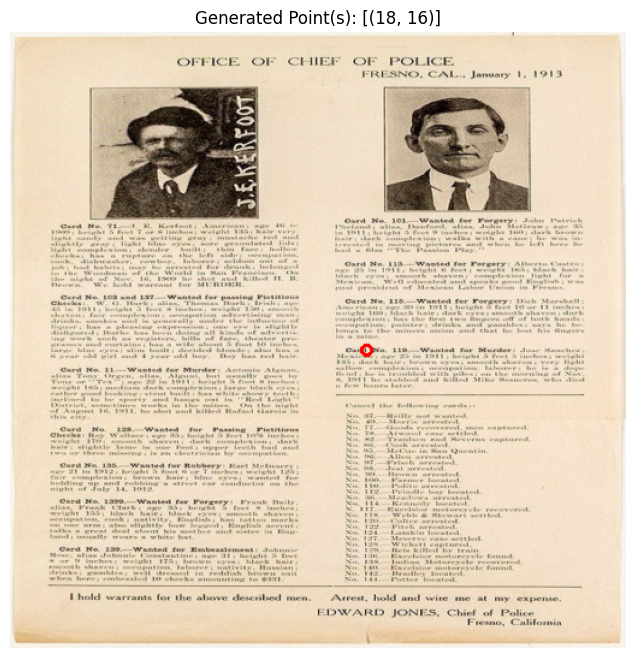

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageDraw
from torch.nn import functional as F # Needed for softmax
TEST_BATCH = 10
TEST_IDX = 0 # or 1 as batch size is 2

# Assuming the following are already defined and configured:
# - model: Your trained VisionLanguageModel instance, already moved to DEVICE
# - test_loader: Your DataLoader for the test set
# - tokenizer: Your tokenizer instance
# - DEVICE: Your computation device ('cuda' or 'cpu')
# - tensor_to_image: Your function to convert normalized tensor back to PIL Image
# - IMAGE_SIZE, NUM_BINS, CONTEXT_LENGTH: Global constants

def generate_sample_from_test_loader(
    model,
    test_loader,
    tokenizer,
    device,
    max_new_tokens=40,
    temperature=0.8,
    top_k=10
):
    """
    Generates a prediction for one sample from the test loader and visualizes it.
    Generation loop is implemented *within* this function.

    Args:
        model: The trained VisionLanguageModel.
        test_loader: DataLoader for the test set.
        tokenizer: The tokenizer used for training.
        device: The computation device ('cuda' or 'cpu').
        max_new_tokens (int): Max tokens to generate after the prompt.
        temperature (float): Softmax temperature for sampling.
        top_k (int): K for top-k sampling (0 or None to disable).

    Returns:
        None. Displays the image with prompt and generated output.
    """
    if not test_loader or len(test_loader.dataset) == 0:
        print("Test loader is empty or not available.")
        return

    model.eval()  # Set the model to evaluation mode

    try:
        # Get a single batch from the test loader
        with torch.no_grad(): # No need to track gradients during inference
            my_iter = iter(test_loader)
            for i in range(TEST_BATCH):
                _ = next(my_iter)
            batch = next(my_iter)

            if batch is None:
                print("Test loader yielded an empty batch.")
                return
            if batch['image'].shape[0] == 0:
                 print("Test loader yielded a batch with 0 items.")
                 return

            # --- 1. Prepare Initial Inputs ---
            image_tensor = batch['image'][TEST_IDX:TEST_IDX+1].to(device) # (1, 3, H, W)
            prompt_ids = batch['prompt_ids'][TEST_IDX:TEST_IDX+1].to(device) # (1, T_prompt)
            prompt_attention_mask = batch['prompt_attention_mask'][TEST_IDX:TEST_IDX+1].to(device) # (1, T_prompt)
            label = batch['label'][TEST_IDX]
            B = 1 # We are processing one sample at a time

            print(f"--- Generating Sample (Manual Loop) ---")
            print(f"Original Label/Prompt Hint: {label}")
            prompt_text = tokenizer.decode(prompt_ids[0], skip_special_tokens=False)
            print(f"Input Prompt Tokens Decoded: {prompt_text}")

            # --- 2. Pre-compute Image & Prompt Embeddings (Part of VLM Forward Logic) ---
            image_embeds_raw = model.vision_encoder(image_tensor) # (1, N_img, C)
            image_embeds_decoder = model.multimodal_projector(image_embeds_raw) # (1, N_img, C)
            prompt_embeds_decoder = model.decoder.token_embedding_table(prompt_ids) # (1, T_prompt, C)

            result_start_token_id = tokenizer.encode("<result_start>", add_special_tokens=False)[0]
            result_start_embed = model.decoder.token_embedding_table(
                torch.tensor([[result_start_token_id]], device=device) # Shape (1, 1, C)
            )

            # The initial sequence fed to the decoder blocks consists of image + prompt
            current_embeds = torch.cat([
                image_embeds_decoder,
                prompt_embeds_decoder,
                result_start_embed # Add the embedding for the first expected output token
                ], dim=1)
            # current_embeds = torch.cat([image_embeds_decoder, prompt_embeds_decoder], dim=1) # (1, T_initial, C)
            generated_ids = [] # Store newly generated IDs

            # --- 3. Autoregressive Generation Loop ---
            for _ in range(max_new_tokens):
                T_current = current_embeds.shape[1]

                # Truncate if necessary (keep recent context)
                if T_current > model.decoder.max_context: # Access max_context from decoder
                    print(f"Warning: Truncating context from {T_current} to {model.decoder.max_context}")
                    current_embeds = current_embeds[:, -model.decoder.max_context:, :]
                    T_current = model.decoder.max_context

                # Prepare positional embeddings for current length
                pos = torch.arange(0, T_current, dtype=torch.long, device=device)
                pos = pos.clamp(max=model.decoder.max_context - 1) # Clamp indices
                pos_emb = model.decoder.position_embedding_table(pos).unsqueeze(0) # (1, T_current, C)
                x = current_embeds + pos_emb

                # Create attention mask (all ones, causal handles future)
                # Note: We don't need padding mask here as we handle one sequence without padding
                attention_mask = torch.ones(B, T_current, device=device, dtype=torch.long)

                # Pass through Decoder Blocks
                for block in model.decoder.blocks:
                    # We assume the block forward takes (x, attention_mask)
                    x = block(x, attention_mask=attention_mask)

                # Final Layer Norm and LM Head for the *last* token prediction
                x = model.decoder.ln_f(x[:, -1:, :]) # (B, 1, C) -> (1, 1, C)
                logits = model.decoder.lm_head(x)    # (B, 1, V) -> (1, 1, V)
                logits = logits.squeeze(1)           # (B, V)    -> (1, V)

                # Sampling
                logits = logits / temperature
                if top_k is not None and top_k > 0:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = -float('Inf')

                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1) # (1, 1) # test distribution
                # idx_next = torch.argmax(logits, dim=-1, keepdim=True) # test deterministic

                # Store generated ID
                generated_ids.append(idx_next)

                # Stop if EOS token is generated
                if idx_next.item() == tokenizer.eos_token_id:
                    print("EOS token generated.")
                    break

                # Prepare for next iteration: Append embedding of new token
                next_token_embed = model.decoder.token_embedding_table(idx_next) # (1, 1, C)
                current_embeds = torch.cat([current_embeds, next_token_embed], dim=1) # Append along sequence dim

            # --- 4. Combine and Decode Results ---
            if generated_ids:
                generated_ids_tensor = torch.cat(generated_ids, dim=1) # (1, T_generated)
                initial_target_ids = torch.tensor([[result_start_token_id]], device=device)
                full_generated_sequence_ids = torch.cat([prompt_ids, initial_target_ids, generated_ids_tensor], dim=1)
            else:
                full_generated_sequence_ids = prompt_ids # Nothing was generated

            full_decoded_text = tokenizer.decode(full_generated_sequence_ids[0], skip_special_tokens=False)
            print(f"\nFull Generated Sequence (Manual Loop):\n{full_decoded_text}")

            # --- 5. Visualize ---
            parse_and_visualize_coords(
                image_tensor=image_tensor[0], # Remove batch dim for visualization
                full_decoded_text=full_decoded_text,
                tokenizer=tokenizer,
                image_size=IMAGE_SIZE, # Assumes IMAGE_SIZE is globally defined
                num_bins=NUM_BINS      # Assumes NUM_BINS is globally defined
            )

    except StopIteration:
        print("Test loader is exhausted.")
    except Exception as e:
        print(f"An error occurred during sample generation: {e}")
        import traceback
        traceback.print_exc()

def parse_coordinate_tokens(text, tokenizer, num_bins):
    """
    Parses generated text to extract coordinate bin tokens.

    Args:
        text (str): The decoded output text from the model.
        tokenizer: The tokenizer.
        num_bins (int): The number of coordinate bins used.

    Returns:
        list[tuple(int, int)]: A list of (x_bin, y_bin) tuples, or None if parsing fails.
    """
    coords = []
    try:
        # Basic parsing - look for the pattern
        x_start_token = "<pointx_start>"
        x_end_token = "<pointx_end>"
        y_start_token = "<pointy_start>"
        y_end_token = "<pointy_end>"
        result_end_token = "<result_end>"

        # Find where the actual results start
        try:
             start_index = text.index("<result_start>") + len("<result_start>")
        except ValueError:
             print("Warning: <result_start> not found in generated text.")
             return None

        # Find where results end
        try:
             end_index = text.index(result_end_token, start_index)
        except ValueError:
             end_index = len(text) # Use end of string if <result_end> is missing
             print(f"Warning: {result_end_token} not found. Parsing until end of string.")


        current_pos = start_index
        while current_pos < end_index:
            # Find next X coordinate
            x_start_idx = text.find(x_start_token, current_pos)
            if x_start_idx == -1 or x_start_idx >= end_index: break # No more x points found
            x_start_idx += len(x_start_token)

            x_end_idx = text.find(x_end_token, x_start_idx)
            if x_end_idx == -1 or x_end_idx >= end_index: break # Malformed

            x_token_str = text[x_start_idx:x_end_idx].strip()

            # Find next Y coordinate (must follow X)
            y_start_idx = text.find(y_start_token, x_end_idx)
            if y_start_idx == -1 or y_start_idx >= end_index: break # No corresponding y point
            y_start_idx += len(y_start_token)

            y_end_idx = text.find(y_end_token, y_start_idx)
            if y_end_idx == -1 or y_end_idx >= end_index: break # Malformed

            y_token_str = text[y_start_idx:y_end_idx].strip()
            
            x_token_str = x_token_str[:-1]
            y_token_str = y_token_str[:-1]

            # Convert token strings to bin numbers
            try:
                x_bin = int(x_token_str.split("_")[-1])
                y_bin = int(y_token_str.split("_")[-1])
                if 0 <= x_bin < num_bins and 0 <= y_bin < num_bins:
                    coords.append((x_bin, y_bin))
                else:
                    print(f"Warning: Parsed bin indices out of range ({x_bin}, {y_bin}). Skipping.")
            except (ValueError, IndexError):
                print(f"Warning: Could not parse bins from tokens '{x_token_str}', '{y_token_str}'. Skipping.")

            # Move search position past the found Y token
            current_pos = y_end_idx + len(y_end_token)

        return coords if coords else None

    except Exception as e:
        print(f"Error during coordinate parsing: {e}")
        return None


def parse_and_visualize_coords(image_tensor, full_decoded_text, tokenizer, image_size, num_bins):
    """Parses coords and draws them on the image."""
    parsed_bins = parse_coordinate_tokens(full_decoded_text, tokenizer, num_bins)

    # Convert tensor to PIL image for drawing
    try:
        pil_image = tensor_to_image(image_tensor.cpu()) # Ensure tensor is on CPU
    except Exception as e:
        print(f"Error converting tensor to image: {e}")
        # Display raw tensor info if conversion fails
        plt.figure(figsize=(6, 6))
        plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy()) # Basic display
        plt.title("Raw Image Tensor (Conversion Failed)")
        plt.axis('off')
        plt.show()
        return

    draw = ImageDraw.Draw(pil_image)
    radius = 5 # Radius of the drawn point

    if parsed_bins:
        print(f"\nParsed Coordinate Bins: {parsed_bins}")
        bin_size_pixels = image_size / num_bins
        for x_bin, y_bin in parsed_bins:
            # Calculate center of the bin in pixels
            center_x = (x_bin + 0.5) * bin_size_pixels
            center_y = (y_bin + 0.5) * bin_size_pixels

            # Draw a circle
            bbox = [center_x - radius, center_y - radius, center_x + radius, center_y + radius]
            draw.ellipse(bbox, outline="red", width=3)
            # Optional: Draw bin boundaries for debugging
            # draw.rectangle([x_bin*bin_size_pixels, y_bin*bin_size_pixels, (x_bin+1)*bin_size_pixels, (y_bin+1)*bin_size_pixels], outline="blue", width=1)

        title = f"Generated Point(s): {parsed_bins}"
    else:
        print("\nCould not parse valid coordinates from the generated text.")
        title = "No Coordinates Parsed"

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(pil_image))
    plt.title(title)
    plt.axis('off')
    plt.show()


# --- Example Usage ---
if __name__ == "__main__":
    # This assumes 'model', 'test_loader', 'tokenizer', 'DEVICE',
    # 'tensor_to_image', 'IMAGE_SIZE', 'NUM_BINS' are defined and loaded correctly
    # Example placeholder values (replace with your actual loaded objects)
    # model = VisionLanguageModel(...)
    # model.load_state_dict(torch.load('your_model_checkpoint.pth'))
    # model.to(DEVICE)
    # tokenizer, _ = get_tokenizer()
    # test_loader = create_test_dataloader()

    # Check if essential components exist before running
    if 'model' in locals() and 'test_loader' in locals() and 'tokenizer' in locals():
         generate_sample_from_test_loader(model, test_loader, tokenizer, DEVICE)
    else:
         print("Please ensure 'model', 'test_loader', and 'tokenizer' are loaded before running the generation.")

